In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt

# Manually specifying column names
column_names = ['Gender', 'Age', 'Type of Injury', 'Area', 'Type of Vehicle', '2020', '2021', '2022']

# Try using 'ISO-8859-1' or 'latin1' encoding
Dataset = pd.read_csv('C:/Users/kaspe/Documents/GitHub/KCL_Eksamensprojekt/AI_Model_Training/data/20244281821457313338UHELDK129906013912.csv', names=column_names, sep=';', encoding='ISO-8859-1')

df = Dataset
df.head()

,Gender,Age,Type of Injury,Area,Type of Vehicle,2020,2021,2022
0,Mænd,0-17 år,Personskade i alt,Region Hovedstaden,Almindelig personbil,9,7,4
1,Mænd,0-17 år,Personskade i alt,Region Hovedstaden,Taxi,0,0,0
2,Mænd,0-17 år,Personskade i alt,Region Hovedstaden,Køretøj 0-3.500 kg under udrykning,0,0,0
3,Mænd,0-17 år,Personskade i alt,Region Hovedstaden,Varebil 0-3.500 kg.,0,1,0
4,Mænd,0-17 år,Personskade i alt,Region Hovedstaden,Lastbil over 3.500 kg.,0,0,0


In [27]:
# Proceed with the data preparation

# Merge 'Knallert' and 'Knallert 45' into 'Knallert'
df['Type of Vehicle'] = df['Type of Vehicle'].replace(['Knallert 45'], 'Knallert')

# Sum the incidents from 2020, 2021, 2022 into a single 'Total Incidents' column
df['Total Incidents'] = df[['2020', '2021', '2022']].sum(axis=1)

# Drop the now unnecessary year columns, since we have total incidents
df.drop(['2020', '2021', '2022'], axis=1, inplace=True)

# Filter out rows where 'Type of Injury' equals 'Personskade i alt'
df = df[df['Type of Injury'] != 'Personskade i alt']

# Create a copy of the dataframe for encoding
df_encoded = df.copy()

# Initialize a label encoder for each categorical column
label_encoders = {}
for column in ['Gender', 'Age', 'Type of Injury', 'Area', 'Type of Vehicle']:
    le = LabelEncoder()
    df_encoded[column] = le.fit_transform(df_encoded[column])
    label_encoders[column] = le

# Now, `df_encoded` contains integers instead of string categories


In [28]:
df.head()

,Gender,Age,Type of Injury,Area,Type of Vehicle,Total Incidents
60,Mænd,0-17 år,Dræbte,Region Hovedstaden,Almindelig personbil,2
61,Mænd,0-17 år,Dræbte,Region Hovedstaden,Taxi,0
62,Mænd,0-17 år,Dræbte,Region Hovedstaden,Køretøj 0-3.500 kg under udrykning,0
63,Mænd,0-17 år,Dræbte,Region Hovedstaden,Varebil 0-3.500 kg.,0
64,Mænd,0-17 år,Dræbte,Region Hovedstaden,Lastbil over 3.500 kg.,0


In [29]:
df_encoded

,Gender,Age,Type of Injury,Area,Type of Vehicle,Total Incidents
60,1,0,1,0,0,2
61,1,0,1,0,9,0
62,1,0,1,0,6,0
63,1,0,1,0,10,0
64,1,0,1,0,7,0
...,...,...,...,...,...,...
4315,2,5,2,2,5,0
4316,2,5,2,2,5,0
4317,2,5,2,2,3,0
4318,2,5,2,2,4,0


In [40]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import LearningRateScheduler
import math

# Preparing the data
X = df_encoded.drop(['Type of Injury', 'Total Incidents'], axis=1)
y = df_encoded['Type of Injury']
y = to_categorical(y)

# Define sample weights based on 'Total Incidents'
sample_weights = df_encoded['Total Incidents']

# Split the data, ensuring weights are split correspondingly
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    X, y, sample_weights, test_size=0.2, random_state=42)

def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lrate = LearningRateScheduler(step_decay)

model = Sequential([
    Dense(64, input_shape=(X_train.shape[1],), activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              weighted_metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    sample_weight=weights_train,
                    epochs=100,
                    batch_size=10,
                    validation_split=0.1,
                    callbacks=[lrate])




# Evaluate the model on the test data
loss, accuracy, weighted_accuracy = model.evaluate(X_test, y_test, sample_weight=weights_test)  # Including sample weights here as well

# Now print both accuracies
print(f"Test Unweighted Accuracy: {accuracy*100:.2f}%")
print(f"Test Weighted Accuracy: {weighted_accuracy*100:.2f}%")



Epoch 1/100


C:\Users\kaspe\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\data_adapter.py:1798: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


234/234 [==============================] - 1s 2ms/step - loss: 2.6567 - accuracy: 0.3203 - weighted_accuracy: 0.4518 - val_loss: 1.2720 - val_accuracy: 0.3615 - val_weighted_accuracy: 0.6955 - lr: 0.0100
Epoch 2/100
234/234 [==============================] - 0s 2ms/step - loss: 2.4239 - accuracy: 0.3255 - weighted_accuracy: 0.5706 - val_loss: 1.2758 - val_accuracy: 0.3615 - val_weighted_accuracy: 0.6955 - lr: 0.0100
Epoch 3/100
234/234 [==============================] - 0s 2ms/step - loss: 2.3278 - accuracy: 0.3280 - weighted_accuracy: 0.5613 - val_loss: 1.3232 - val_accuracy: 0.3462 - val_weighted_accuracy: 0.5149 - lr: 0.0100
Epoch 4/100
234/234 [==============================] - 0s 2ms/step - loss: 2.4137 - accuracy: 0.3246 - weighted_accuracy: 0.5524 - val_loss: 1.2191 - val_accuracy: 0.3615 - val_weighted_accuracy: 0.6955 - lr: 0.0100
Epoch 5/100
234/234 [==============================] - 0s 2ms/step - loss: 2.2856 - accuracy: 0.3276 - weighted_accuracy: 0.5788 - val_loss: 1.2146 

1/1 [==============================] - 0s 19ms/step


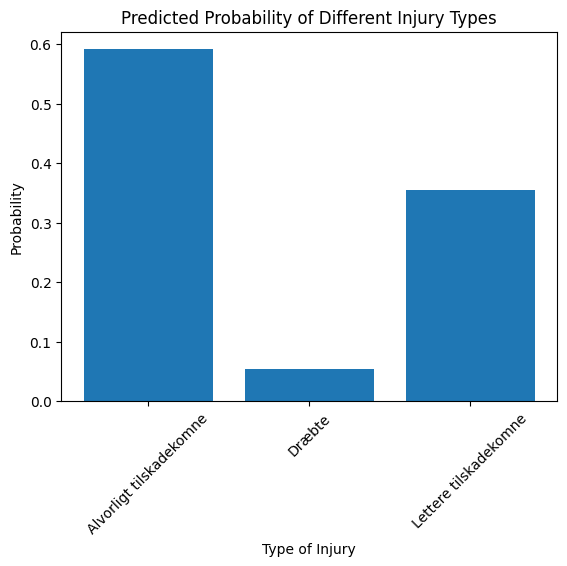

In [48]:
def predict_injury_type(user_data):
    # Convert user data into DataFrame
    input_df = pd.DataFrame([user_data])
    
    # Encode user data using the same label encoders used during training
    for column in label_encoders:
        if column in input_df.columns:  # Ensure we're only encoding expected columns
            input_df[column] = label_encoders[column].transform(input_df[column])
    
    # Predict probabilities
    probabilities = model.predict(input_df)[0]
    
    # Decode the predicted probabilities back to labels
    injury_types = {index: label for index, label in enumerate(label_encoders['Type of Injury'].classes_)}
    predicted_probs = {injury_types[i]: prob for i, prob in enumerate(probabilities)}

    return predicted_probs

user_input = {
    'Gender': 'Kvinder',
    'Age': '18-24 år',
    'Area': 'Region Syddanmark',
    'Type of Vehicle': 'Taxi'
}
predicted_probabilities = predict_injury_type(user_input)

# Visualizing the probabilities
plt.bar(predicted_probabilities.keys(), predicted_probabilities.values())
plt.title('Predicted Probability of Different Injury Types')
plt.xlabel('Type of Injury')
plt.ylabel('Probability')
plt.xticks(rotation=45)
plt.show()


In [49]:

model_output = model.predict(user_input)
print("Raw model output:", model_output)


ValueError: Failed to find data adapter that can handle input: (<class 'dict'> containing {"<class 'str'>"} keys and {"<class 'str'>"} values), <class 'NoneType'>